<a href="https://colab.research.google.com/github/luisrondan2001/bioinformatic/blob/main/MD_sistema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema de partículas que interactúan a través de un potencial de Lennard-Jones**

---



---



---


⚛*MPC*

In [ ]:
import numpy as np #importing the numpy library



##1. **Posiciones iniciales en configuración cristalina**

---

Cúbico simple:

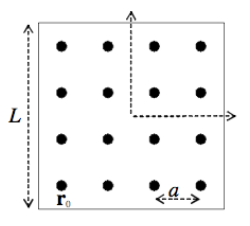







* L ➡ longitud de la caja de simulación
* M ➡ celdas unitarias en cada dimensión (número de celdas unitarias = M$^3$)
* N ➡ número total de partículas: $N=M^3$
* ρ ➡ densidad: $ρ = N/L^3$
* a ➡ espaciamiento de la red: $a=L/M$



In [ ]:
N=125
rho=0.8
M=int(np.rint(N**(1/3)))
L=(N/rho)**(1/3)
a=L/M


##2. **Ubicación de posiciones iniciales en los nodos de una red cúbica simple**


In [ ]:
file=open('coordinates.xyz','w') #file to save xyz coordinates

In [ ]:
#Initial Positions
def init_pos(U_cells, lattice):
    pos = []
    for x in range(U_cells):
        for y in range(U_cells):
            for z in range(U_cells):
                pos.append([x,y,z])
    pos = np.array(pos)*lattice
    return pos

In [ ]:
r = init_pos(M, a)

In [ ]:
#xyz file
file.write('%i'%N+'\n\n')
for i in range(int(len(r))):
    file.write('A'+'%14.8f'%r[i,0]+' '+'%14.8f'%r[i,1]+' '+'%14.8f'%r[i,2]+'\n')
file.close()

##3. **Condiciones de borde**
<img src="https://isaacs.sourceforge.io/phys/images/these-seb/pbc-seb.png" width="200"/>

1. Los átomos que abandonan la región de simulación en un límite vuelven a entrar en la región por la cara opuesta.
2. Los átomos interactúan con átomos reales y de imagen.


In [ ]:
#pbc code
def pbc(x, L_box):
    x=x-np.rint(x/L_box)*L_box
    return x

##4. **Potenciales de interacción**
####**Expansión de interacciones a dos potenciales corporales (Sistemas atómicos)**

1. Potencial de esfera dura
2. Potencial de pozo cuadrado
3. Potencial de esfera blanda
4. Potencial de Buckingham
5. **Potencial de Lennard-Jones**

####**Cálculo de la energía potencial de Lennard-Jones**

<img src="https://onlinelibrary.wiley.com/cms/asset/b8781787-6e51-4af1-8ff1-cd7bd395ac05/jcc26368-fig-0001-m.jpg" width="260"/>

* **Truncado de interacciones:** es conveniente truncar los potenciales por pares para reducir el costo computacional del cálculo de la interacción (corte).

   $u^{cut-shift}(r)=\left\{\begin{matrix}u^{LJ}(r)-u^{LJ}(r_c), \quad if \quad r\leq r_c\\ 0 \hspace{51mm} r > r_c \end{matrix}\right.$





In [ ]:
#Forces and potential energy
def force_LJ(r, L_box):
    F = np.zeros((N,3))
    cutoff2 = cutoff*cutoff
    Upot = 0.0
    for i in range(N):
        for j in range(i+1, N):
            rij = pbc(r[i]-r[j], L_box)
            d2 = rij[0]*rij[0] + rij[1]*rij[1] + rij[2]*rij[2]
            d4 = d2*d2; d6 = d4*d2; d8 = d6*d2; d12 = d6*d6; d14 = d8*d6
            if d2<cutoff2:
                F[i] = F[i] + (48 / d14 - 24 /d8)*rij
                F[j] = F[j] - (48 / d14 - 24 /d8)*rij
                cf4 = cutoff2**2; cf6 = cutoff2*cf4; cf12 = cf6*cf6
                Upot = Upot + 4.*( 1./ d12 - 1./d6) - 4.*( 1./ cf12 - 1./cf6)
    return np.array(F), Upot

##5. **Ecuaciones de movimiento**
En física, las ecuaciones de movimiento son ecuaciones que describen el comportamiento de un sistema físico en términos de su movimiento en función del tiempo.

####**¿Cómo solucionarlos?**
* Discretización de ecuaciones de movimiento.
* Integradores:
     * Algoritmo de Euler
     * Algoritmo de salto de rana
     * Algoritmo de Verlet
     * **Algoritmo de velocidad Verlet**

####**Resolución de las ecuaciones de movimiento: algoritmo Velocity Verlet**

  <img src="https://raw.githubusercontent.com/MargotPC/System-of-particles-MD/main/velocity-verlet.png" ancho="260"/>


Primero debemos definir las velocidades iniciales:

In [ ]:
kBT = 1.5 #temperature in kB(boltzman constant)
mass=1 #hidrogen 1u
#Initial velocities
vel = np.random.normal(loc=0, scale=np.sqrt(kBT/mass), size=(N,3)) #Maxwell-Boltzmann distribution

Ahora podemos implementar la función del algoritmo Verlet de velocidad:



In [ ]:
# Velocity verlet algorithm
def time_step_vVerlet(r, vel,F):
    r = pbc(r, L) + vel * dt + 0.5 * F * dt * dt
    vel = vel + F*0.5*dt
    F,pot = force_LJ(r, L)
    vel = vel + F*0.5*dt
    return r, vel, F, pot

##6. **Ejecución de simulación para conjunto microcanónico (NVE)**





In [ ]:
file2=open('trajectory.xyz','w') #file to save the trajectory

In [ ]:
dt=0.001
steps=5000
Nsave=50
time=0.0
cutoff=2.0
traject=[] #empty array to save positions xyz of the system

F,pot = force_LJ(r, L)

for t in range(steps+Nsave):
    time = time + dt
    r, vel, F, pot = time_step_vVerlet(r, vel, F)
    traject.append(r)
    if t%Nsave==0:
        print('timestep = ', t, ', ULJ = ', pot)

timestep =  0 , ULJ =  -512.6472239049408
timestep =  50 , ULJ =  -395.24450625657266
timestep =  100 , ULJ =  -404.0808840897476
timestep =  150 , ULJ =  -438.8501853811203
timestep =  200 , ULJ =  -464.0636291307341
timestep =  250 , ULJ =  -491.7962156494547
timestep =  300 , ULJ =  -505.20194002894783
timestep =  350 , ULJ =  -479.6107612106829
timestep =  400 , ULJ =  -484.5844249836452
timestep =  450 , ULJ =  -471.2152104662285
timestep =  500 , ULJ =  -456.69238298052653
timestep =  550 , ULJ =  -473.977949243455
timestep =  600 , ULJ =  -478.3682635028493
timestep =  650 , ULJ =  -467.2409492298863
timestep =  700 , ULJ =  -482.0181606253284
timestep =  750 , ULJ =  -481.22932951589326
timestep =  800 , ULJ =  -463.96865201784556
timestep =  850 , ULJ =  -458.18105885520646
timestep =  900 , ULJ =  -463.6018515927682
timestep =  950 , ULJ =  -481.2524534953623
timestep =  1000 , ULJ =  -472.4762636827323
timestep =  1050 , ULJ =  -480.3709576866312
timestep =  1100 , ULJ =  -4

In [ ]:
#Creating the xyz trajectory file
data = np.array(traject)
for i in range(0,int(len(data)),Nsave):
    file2.write('%i'%len(data[i])+'\n\n')
    for j in range(int(len(data[i]))):
        file2.write('A'+'%14.8f'%data[i,j,0]+' '+'%14.8f'%data[i,j,1]+' '+'%14.8f'%data[i,j,2]+'\n')
file2.close()